# Generalized Lasso examples

Minimization problem of Generalized Lasso can be described as follows.

$$
\min_{w, z}\left\{ \frac{1}{2n}\| y - Xw \|_2^2 + \alpha \|z\|_1 \right\} \ \ \ \text{subject to} \ \ \  Dw = z
$$


By choosing proper matrix $D$, you can easily run several algorithms like

* fused Lasso
* cluster Lasso
* trend filtering

and fused Lasso is shown in this example.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1

# add parent directory to load spmimage
import sys
sys.path.append('..')

In [2]:
def show_plot(coef, value, coef_expected = None, value_expected = None, suptitle=None):
    # Plot signal and result
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(coef, label='original')
    if coef_expected is not None:
        plt.plot(coef_expected, label='expected')    
    plt.title('coeficients')
    plt.legend(loc=1)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(value, label='original')
    if value_expected is not None:
        plt.plot(value_expected, label='expected')        
    
    plt.title('value')
    plt.legend(loc=1)
    plt.grid()
    
    if suptitle is not None:
        plt.suptitle(suptitle)    

    plt.tight_layout()    
    if suptitle is not None:
        plt.subplots_adjust(top=0.85)

In [3]:
# fix the seed of random
np.random.seed(0)

## Fused Lasso

Fused Lasso minimises the following objective function.

$$
\frac{1}{2n}\| y - Xw \|_2^2 + \alpha_1\sum_{j=1}^p\left|w\right| + \alpha_2 \sum_{j=2}^p\left|w_j - w_{j-1}\right|,
$$

where $\alpha_1$ tunes sparcity in $w$ and $\alpha_2$ does fusibility. In Generalized Lasso form, $D$ will be

$$
D = \frac{1}{\alpha} \left( \begin{array}{c}
\alpha_1I_p\\
\alpha_2 D_{\text{f}}
\end{array}
\right),
$$

where

$$
D_{\text{f}} = \left(\begin{array}{cccccc}
-1 & 1 & 0 & \ldots & 0 & 0 \\
0 & -1 & 1 & \ldots & 0 & 0 \\
\ & \vdots & \  & \ddots & \  & \vdots \\
0 & 0 & 0 & -1 & 1 & 0 \\
0 & 0 & 0 & \ldots & -1 & 1
\end{array}
\right).
$$

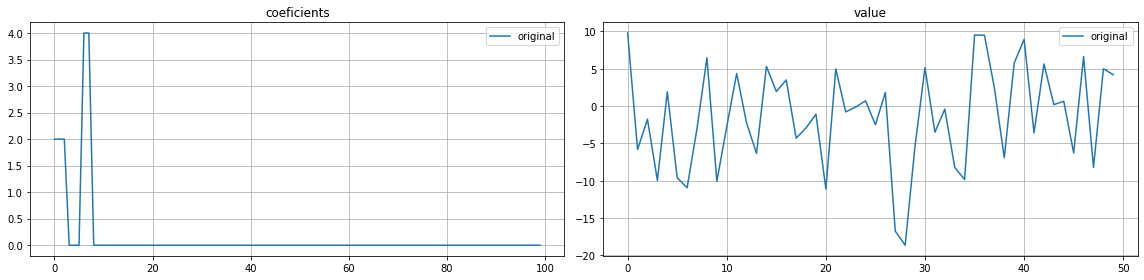

In [4]:
# input signals

n_samples = 50
n_features = 100
beta = np.zeros(n_features)
beta[0:3] = 2
beta[6:8] = 4

X = np.random.normal(0.0, 1.0, (n_samples, n_features))
y = X.dot(beta) + np.random.normal(0, 1)
show_plot(beta, y)

In [5]:
from spmimage.linear_model import FusedLassoADMM as FusedLasso

def run_fused_lasso(l1, l2):

    clf = FusedLasso(alpha=0.1, sparse_coef=l1, trend_coef=l2, tol=1e-8)
    clf.fit(X, y)
    
    glasso_signal = clf.coef_
    glasso_predict = X.dot(glasso_signal)    
    
    # Plot signal and result
    show_plot(beta, y, glasso_signal, glasso_predict, 'L1={0} and L2={1}'.format(l1, l2))
    return np.linalg.norm(y - glasso_predict), glasso_signal

error : 2.1743
number of nonzero coefficients : 100
number of unique coefficients : 100
CPU times: user 368 ms, sys: 56.4 ms, total: 425 ms
Wall time: 292 ms


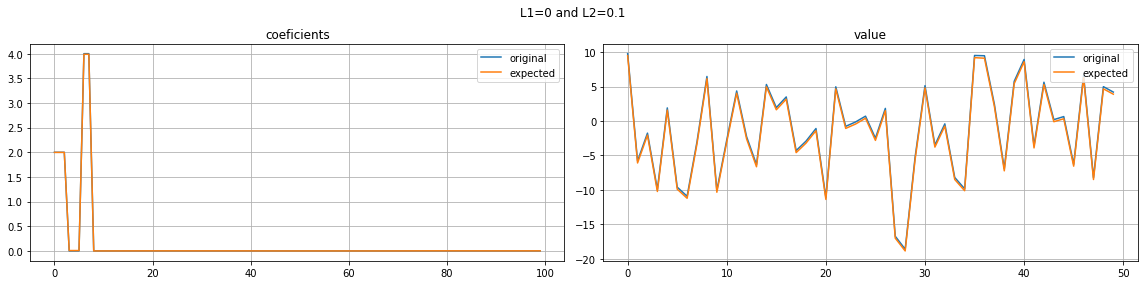

In [6]:
%%time

error, coef = run_fused_lasso(0, 0.1)
nonzero_idx = np.where(coef != 0)[0]
print('error : {0:.4f}'.format(error))
print('number of nonzero coefficients : {0}'.format(len(nonzero_idx)))
print('number of unique coefficients : {0}'.format(len(np.unique(coef))))

error : 2.1457
number of nonzero coefficients : 100
number of unique coefficients : 100
CPU times: user 260 ms, sys: 49.5 ms, total: 310 ms
Wall time: 243 ms


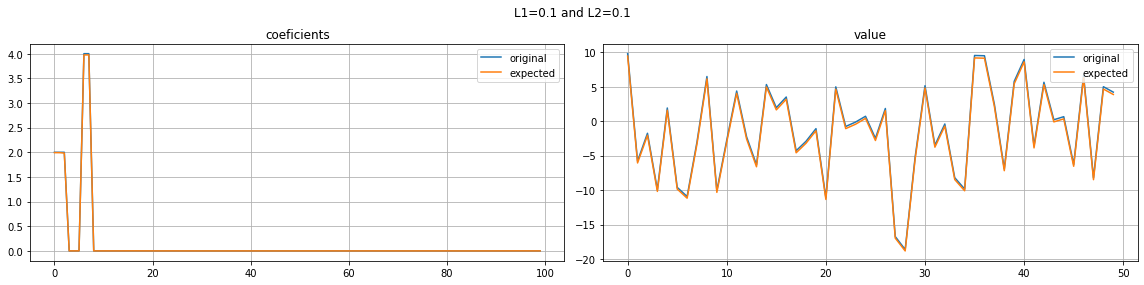

In [7]:
%%time

error, coef = run_fused_lasso(0.1, 0.1)
nonzero_idx = np.where(coef != 0)[0]
print('error : {0:.4f}'.format(error))
print('number of nonzero coefficients : {0}'.format(len(nonzero_idx)))
print('number of unique coefficients : {0}'.format(len(np.unique(coef))))

error : 2.1644
number of nonzero coefficients : 100
number of unique coefficients : 100
CPU times: user 336 ms, sys: 50.9 ms, total: 387 ms
Wall time: 267 ms


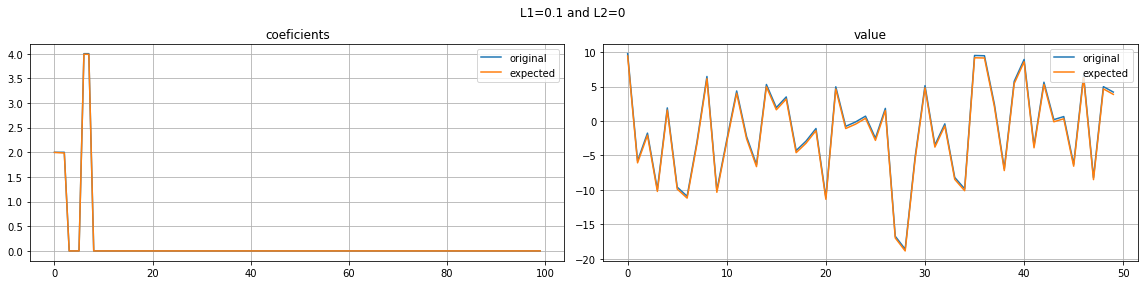

In [8]:
%%time

error, coef = run_fused_lasso(0.1, 0)
nonzero_idx = np.where(coef != 0)[0]
print('error : {0:.4f}'.format(error))
print('number of nonzero coefficients : {0}'.format(len(nonzero_idx)))
print('number of unique coefficients : {0}'.format(len(np.unique(coef))))

## Trend Filtering

Trend Filtering minimises the following objective function.

$$
\frac{1}{2n}\| y - Xw \|_2^2 + \alpha_1\sum_{j=1}^p\left|w\right| + \alpha_2 \sum_{j=2}^p\left|2w_j - w_{j-1} -w_{j+1}\right|,
$$

where $\alpha_1$ tunes sparcity in $w$ and $\alpha_2$ does smoothness. In Generalized Lasso form, $D$ will be

$$
D = \frac{1}{\alpha} \left( \begin{array}{c}
\alpha_1I_p\\
\alpha_2 D_{\text{tf}}
\end{array}
\right),
$$

where

$$
D_{\text{tf}} = \left(\begin{array}{cccccc}
1 & -1 & 0 & \ldots & 0 & 0 & 0\\
-1 & 2 & -1 & \ldots & 0 & 0 & 0\\
\ & \vdots & \  & \ddots & \  & \vdots \\
0 & 0 & 0 & \ldots & -1 & 2 & -1 \\
0 & 0 & 0 & \ldots & 0 & -1 & 1
\end{array}
\right).
$$

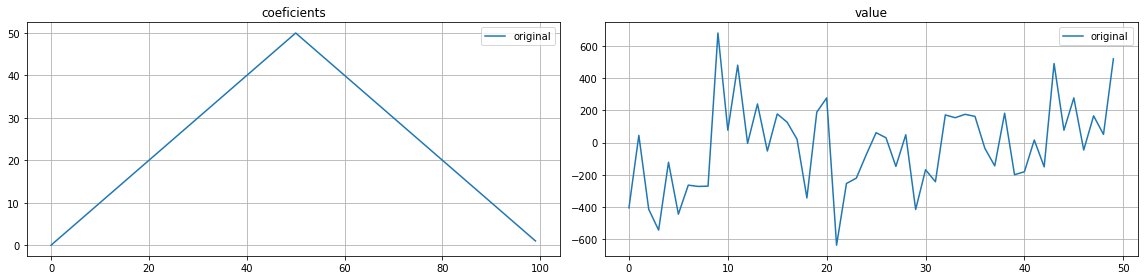

In [9]:
np.random.seed(0)

# make x
beta = [i for i in range(0, 50)] + [50 - i for i in range(0, 50)]
# make y
X = np.random.normal(0.0, 1.0, (n_samples, n_features))
y = X.dot(beta) + np.random.normal(0, 1)
show_plot(beta, y)

In [10]:
from spmimage.linear_model import TrendFilteringADMM as TrendFiltering

def run_trend_filtering(l1, l2):
    clf = TrendFiltering(alpha=0.1, sparse_coef=l1, trend_coef=l2, tol=1e-8)
    clf.fit(X, y)
    
    glasso_signal = clf.coef_
    glasso_predict = X.dot(glasso_signal)    
    
    # Plot signal and result
    show_plot(beta, y, glasso_signal, glasso_predict, 'L1={0} and L2={1}'.format(l1, l2))
    return np.linalg.norm(y - glasso_predict), glasso_signal

error : 2.1850
number of nonzero coefficients : 100
number of unique coefficients : 100
CPU times: user 377 ms, sys: 52 ms, total: 429 ms
Wall time: 267 ms


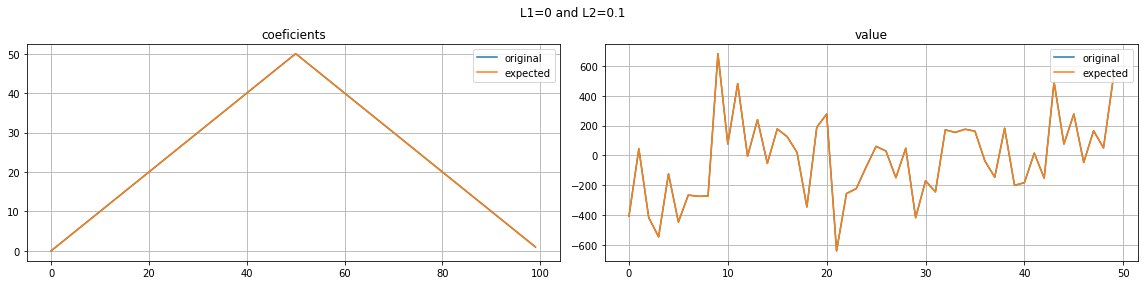

In [11]:
%%time

error, coef = run_trend_filtering(0, 0.1)
nonzero_idx = np.where(coef != 0)[0]
print('error : {0:.4f}'.format(error))
print('number of nonzero coefficients : {0}'.format(len(nonzero_idx)))
print('number of unique coefficients : {0}'.format(len(np.unique(coef))))

## Quadratic Trend Filtering

Quadratic Trend Filtering minimises the following objective function.

$$
\frac{1}{2n}\| y - Xw \|_2^2 + \alpha_1\sum_{j=1}^p\left|w\right| + \alpha_2 \sum_{j=2}^p\left|-w_{j+1}+3w_j-3w_{j-1} + w_{j-2}\right|,
$$

where $\alpha_1$ tunes sparcity in $w$ and $\alpha_2$ does smoothness. In Generalized Lasso form, $D$ will be

$$
D = \frac{1}{\alpha} \left( \begin{array}{c}
\alpha_1I_p\\
\alpha_2 D_{\text{qtf}}
\end{array}
\right),
$$

where 

$$
D_{\text{qtf}} = \left(\begin{array}{cccccc}
1 & -1 & 0 & 0 & \ldots & 0 & 0 & 0 & 0\\
-1 & 2 & -1 & 0 & \ldots & 0 & 0 & 0 & 0\\
1 & -3 & 3 & -1 &  \ldots & 0 & 0 & 0 & 0\\
\ & \ & \vdots & \  & \ddots & \  & \vdots \\
0 & 0 & 0 & 0 & \ldots & -1 & 3 & -3 & 1 \\
0 & 0 & 0 & 0 & \ldots & 0 & 0 & -1 & 1\\
\end{array}
\right).
$$

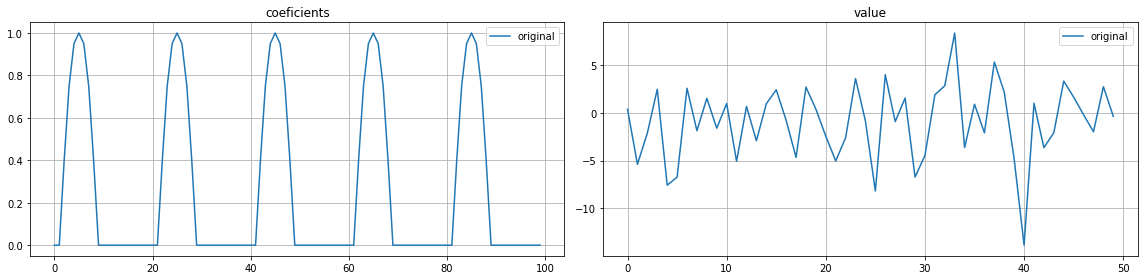

In [12]:
# input signals

n_samples = 50
n_features = 100

beta = np.array([0,0,0.4,0.75,0.95,1,0.95,0.75,0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] * 5)

X = np.random.normal(0.0, 1.0, (n_samples, n_features))
y = X.dot(beta) + np.random.normal(0, 1)
show_plot(beta, y)

In [13]:
from spmimage.linear_model.admm import QuadraticTrendFilteringADMM
def run_quadratic_trend_filtering(l1, l2):
    clf = QuadraticTrendFilteringADMM(alpha=0.1, sparse_coef=l1, trend_coef=l2, tol=1e-8)
    clf.fit(X, y)
    
    glasso_signal = clf.coef_
    glasso_predict = X.dot(glasso_signal)
    
    # Plot signal and result
    show_plot(beta, y, glasso_signal, glasso_predict, 'L1={0} and L2={1}'.format(l1, l2))
    return np.linalg.norm(y - glasso_predict), glasso_signal

error : 5.6739
number of nonzero coefficients : 100
number of unique coefficients : 100
CPU times: user 265 ms, sys: 39.1 ms, total: 304 ms
Wall time: 232 ms


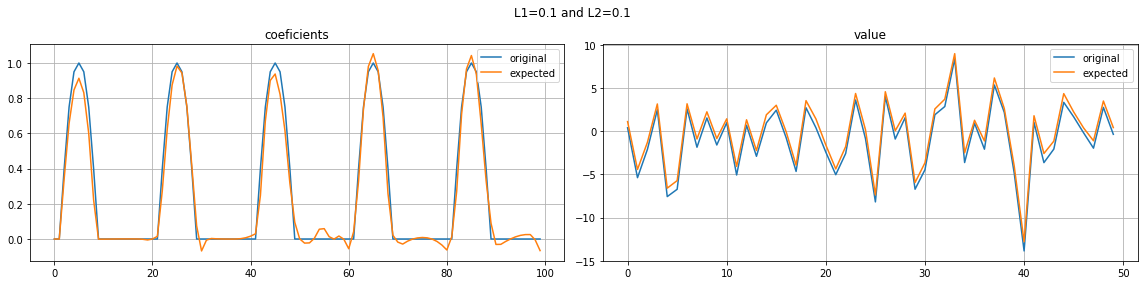

In [14]:
%%time
error, coef = run_quadratic_trend_filtering(0.1, 0.1)
nonzero_idx = np.where(coef != 0)[0]
print('error : {0:.4f}'.format(error))
print('number of nonzero coefficients : {0}'.format(len(nonzero_idx)))
print('number of unique coefficients : {0}'.format(len(np.unique(coef))))